In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import preprocessing 
from keras.optimizers import SGD

C:\Users\yt335\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\yt335\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\yt335\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\yt335\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

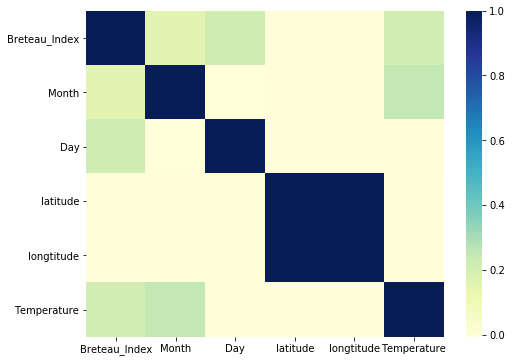

In [3]:
df = pd.read_csv('tainan_mosquito_temp.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.rename(columns = {'布氏指數':'Breteau_Index', '里別':'Village', '經度':'latitude', '緯度':'longtitude'})
column = ['Month', 'Day', 'Village', 'Breteau_Index', 'latitude', 'longtitude', 'Temperature', 'Date']
df2 = df[column]
#df2.groupby('里別').count().sort_values('Month')
columns = ['Breteau_Index', 'Month', 'Day', 'latitude', 'longtitude', 'Temperature', 'Date']
df3 = df2[df2['Village'] == '大同里'][columns]

# 獲取相關度資料
corr_pd = df3.corr()
#使用seaborn做視覺化
%matplotlib inline
# 指定畫幅
plt.figure(figsize=(8,6))
# 繪製熱力圖
sns.heatmap(corr_pd, cmap='YlGnBu')

In [7]:
target_columns = ['Breteau_Index', 'Month', 'Day', 'latitude', 'longtitude', 'Temperature']
df4 = df3[target_columns]
df5 = df2[df2['Village'] == '仁德里'][columns]
df5 = df5[target_columns]
df5

,Breteau_Index,Month,Day,latitude,longtitude,Temperature
54283,0.000000,1,5,120.251887,23.007312,23.0
54278,0.000000,1,5,120.251887,23.007312,21.2
54280,1.666667,1,7,120.251887,23.007312,19.2
54282,1.666667,1,7,120.251887,23.007312,18.4
54247,1.666667,1,7,120.251887,23.007312,17.9
...,...,...,...,...,...,...
53247,6.000000,7,6,120.251887,23.007312,31.6
53281,6.000000,7,6,120.251887,23.007312,31.3
53315,6.000000,7,6,120.251887,23.007312,31.1
53349,6.000000,7,6,120.251887,23.007312,29.3


In [5]:
def normalize(train):  
    x = train.values #returns a numpy array
    scaler = preprocessing.StandardScaler()
#     scaler = preprocessing.MinMaxScaler()
    x_scaled = scaler.fit_transform(x)
    dfx = pd.DataFrame(x_scaled,columns=list(train.columns))
    return dfx
def buildTrain(train, pastDay=3, futureDay=1):
    X_train, Y_train = [], []
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train[i:i+pastDay]))
        Y_train.append(np.array(train[i+pastDay:i+pastDay+futureDay]["Breteau_Index"]))
    return np.array(X_train), np.array(Y_train)
def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]
def splitData(X,Y,rate):
    X_train = X[:int(X.shape[0]*(1-rate))]
    Y_train = Y[:int(Y.shape[0]*(1-rate))]
    X_val = X[int(X.shape[0]*(1-rate)):]
    Y_val = Y[int(Y.shape[0]*(1-rate)):]
    return X_train, Y_train, X_val, Y_val
def buildOneToOneModel(shape):
    model = Sequential()
#     model.add(Dropout(0.1, input_shape=(1,4)))
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2],return_sequences=True))
    # output shape: (1, 1)
    model.add(TimeDistributed(Dense(1)))    # or use model.add(Dense(1))
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.5, nesterov=False) # lr(learning rate 不可以設太大)
    model.compile(loss="mse", optimizer=sgd)
    model.summary()
    return model
def XbuildManyToOneModel(shape):
    model = Sequential()
    model.add(Dropout(0.05, input_shape=(3,6)))
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
#     model.add(Dropout(0.2))
    # output shape: (1, 1)
    model.add(Dense(1))
    sgd = SGD(lr=0.1, momentum=0.9, decay=0.01, nesterov=False)
    model.compile(loss="mse", optimizer=sgd)
    model.summary()
    return model

In [ ]:
#### One to One

In [21]:
#### Normalization
train_norm = normalize(df5)

# build Data, use last 1 hour to predict next 1 hour
X_train, Y_train = buildTrain(train_norm, 1, 1)

# split training data and validation data
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

# shuffle the data, and random seed is 10
X_train, Y_train = shuffle(X_train, Y_train)

X_train.shape, Y_train.shape

((1487, 1, 6), (1487, 1))

In [22]:
# from 2 dimmension to 3 dimension
Y_train = Y_train[:,np.newaxis]
Y_val = Y_val[:,np.newaxis]

In [23]:
model = buildOneToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model.fit(X_train, Y_train, epochs=100, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])
history

C:\Users\yt335\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\yt335\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, return_sequences=True, input_shape=(1, 6))`


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 10)             680       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 1)              11        
Total params: 691
Trainable params: 691
Non-trainable params: 0
_________________________________________________________________
Train on 1487 samples, validate on 166 samples
Epoch 1/100
1487/1487 [==============================] - 0s 185us/step - loss: 0.9140 - val_loss: 0.1491
Epoch 2/100
1487/1487 [==============================] - 0s 12us/step - loss: 0.6356 - val_loss: 0.0459
Epoch 3/100
1487/1487 [==============================] - 0s 12us/step - loss: 0.4815 - val_loss: 0.0334
Epoch 4/100
1487/1487 [==============================] - 0s 13us/step - loss: 0.4187 - val_loss: 0.0331
Epoch 5/100
1487/1487 [==============================]

1487/1487 [==============================] - 0s 11us/step - loss: 0.2992 - val_loss: 0.0253
Epoch 73/100
1487/1487 [==============================] - 0s 11us/step - loss: 0.2991 - val_loss: 0.0253
Epoch 74/100
1487/1487 [==============================] - 0s 11us/step - loss: 0.2990 - val_loss: 0.0253
Epoch 75/100
1487/1487 [==============================] - 0s 10us/step - loss: 0.2988 - val_loss: 0.0253
Epoch 76/100
1487/1487 [==============================] - 0s 11us/step - loss: 0.2987 - val_loss: 0.0253
Epoch 77/100
1487/1487 [==============================] - 0s 11us/step - loss: 0.2986 - val_loss: 0.0253
Epoch 78/100
1487/1487 [==============================] - 0s 11us/step - loss: 0.2985 - val_loss: 0.0253
Epoch 79/100
1487/1487 [==============================] - 0s 10us/step - loss: 0.2984 - val_loss: 0.0253
Epoch 80/100
1487/1487 [==============================] - 0s 11us/step - loss: 0.2982 - val_loss: 0.0253
Epoch 81/100
1487/1487 [==============================] - 0s 10us/st

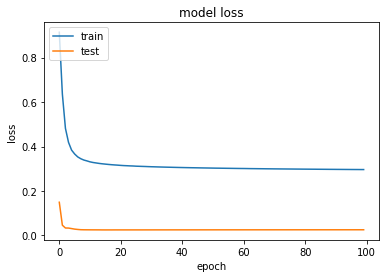

In [24]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
predict = model.predict(X_val)
datelist = list(df3[-(len(X_val)):]['Date'])
list_pre = []
for i in range(len(predict)):
    list_pre.append(predict[i][0][0])
list_real = []
for i in range(Y_val.shape[0]):
    list_real.append(Y_val[i][0][0])
mse_errors = []
for pred_idx in range(X_val.shape[0]):
    mse_errors.append((list_pre[-1]-list_real[pred_idx])**2)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.16947


MSE error for EMA averaging: 0.64124


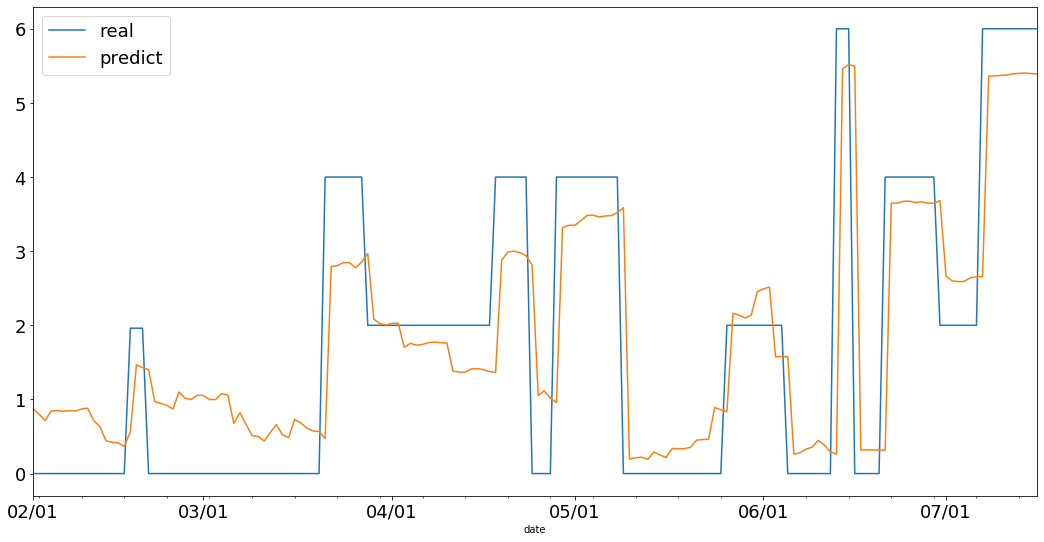

In [26]:
x = df5.values #returns a numpy array
scaler = preprocessing.StandardScaler()
#scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
dfx = pd.DataFrame(x_scaled,columns=list(df5.columns))
#predict = globals()['modelmto'+str(iii)].predict(X_val)

list_pre = []
for i in range(len(predict)):
    a = predict[i][0]
    aa = scaler.inverse_transform([a,0,0,0,0,0])
    #aa = scaler.inverse_transform(np.array([a,0,0,0,0,0,0,0,0]).reshape(1, -1))
    list_pre.append(aa[0][0])

list_real = []
for i in range(Y_val.shape[0]):
    b = Y_val[i][0]
    bb = scaler.inverse_transform([b,0,0,0,0,0])
    #bb = scaler.inverse_transform(np.array([b,0,0,0,0,0,0,0,0]).reshape(1, -1))
    list_real.append(bb[0][0])

mse_errors = []
for pred_idx in range(X_val.shape[0]):
    mse_errors.append((list_pre[pred_idx]-list_real[pred_idx])**2)

inversepredict_df = pd.DataFrame({'date':datelist,'real':np.array(list_real),'predict':np.array(list_pre)})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 15 minutes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))     #optional formatting 

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

In [27]:
k = 18
n = len(X_train)
sse = sum(mse_errors)

AIC = 2*k - 2*np.log(sse)
BIC = n*np.log(sse/n) + k*np.log(n)

print(AIC,BIC)

25.278436153004172 -2758.85120510857


In [ ]:
#### Many to One

In [15]:
#### Normalization
train_norm = normalize(df5)

# build Data, use last 1 hour to predict next 1 hour
X_train, Y_train = buildTrain(train_norm, 3, 1)

# split training data and validation data
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

# shuffle the data, and random seed is 10
X_train, Y_train = shuffle(X_train, Y_train)

X_train.shape, Y_train.shape

((1485, 3, 6), (1485, 1))

In [16]:
model2 = XbuildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
history = model2.fit(X_train, Y_train, epochs=100, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])
history

C:\Users\yt335\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\yt335\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, input_shape=(3, 6))`


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_1 (Dropout)          (None, 3, 6)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                680       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 691
Trainable params: 691
Non-trainable params: 0
_________________________________________________________________
Train on 1485 samples, validate on 166 samples
Epoch 1/100
1485/1485 [==============================] - 0s 193us/step - loss: 0.8047 - val_loss: 0.0622
Epoch 2/100
1485/1485 [==============================] - 0s 21us/step - loss: 0.4342 - val_loss: 0.0446
Epoch 3/100
1485/1485 [==============================] - 0s 20us/step - loss: 0.3665 - val_loss: 0.0627
Epoch 4/100
1485/1485 [===

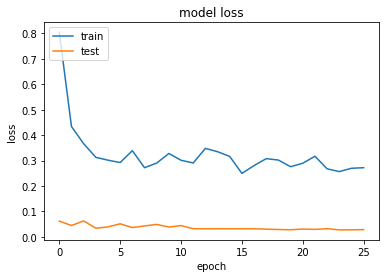

MSE error for EMA averaging: 0.18378


In [17]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

predict = model2.predict(X_val)
datelist = list(df3[-(len(X_val)):]['Date'])
list_pre = []
for i in range(len(predict)):
    list_pre.append(predict[i][0])
list_real = []
for i in range(Y_val.shape[0]):
    list_real.append(Y_val[i][0])
mse_errors = []
for pred_idx in range(X_val.shape[0]):
    mse_errors.append((list_pre[-1]-list_real[pred_idx])**2)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for EMA averaging: 0.71999


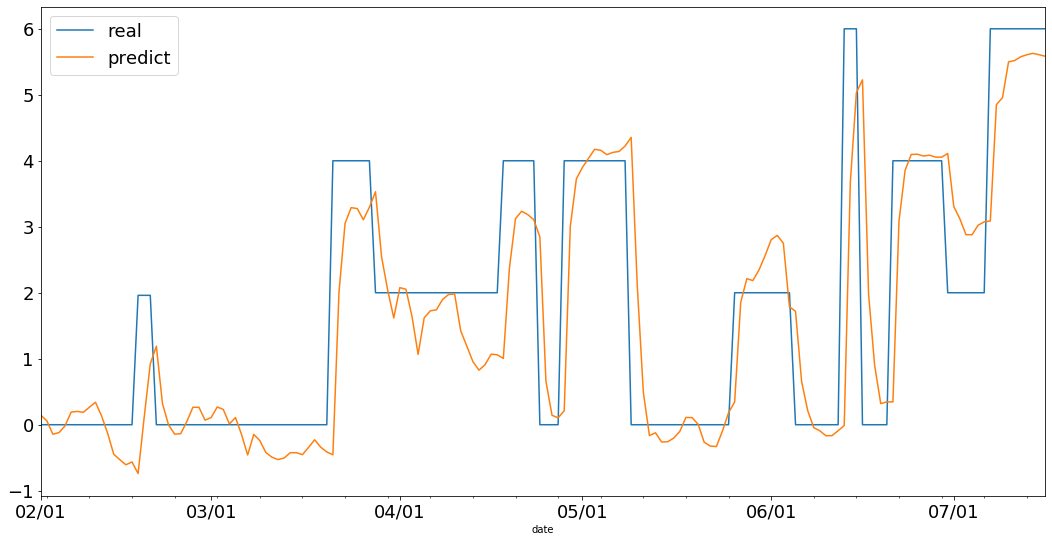

In [19]:
x = df5.values #returns a numpy array
scaler = preprocessing.StandardScaler()
#scaler = preprocessing.MinMaxScaler()
x_scaled = scaler.fit_transform(x)
dfx = pd.DataFrame(x_scaled,columns=list(df5.columns))
#predict = globals()['modelmto'+str(iii)].predict(X_val)

list_pre = []
for i in range(len(predict)):
    a = predict[i][0]
    aa = scaler.inverse_transform([a,0,0,0,0,0])
    #aa = scaler.inverse_transform(np.array([a,0,0,0,0,0,0,0,0]).reshape(1, -1))
    list_pre.append(aa[0])

list_real = []
for i in range(Y_val.shape[0]):
    b = Y_val[i][0]
    bb = scaler.inverse_transform([b,0,0,0,0,0])
    #bb = scaler.inverse_transform(np.array([b,0,0,0,0,0,0,0,0]).reshape(1, -1))
    list_real.append(bb[0])

mse_errors = []
for pred_idx in range(X_val.shape[0]):
    mse_errors.append((list_pre[pred_idx]-list_real[pred_idx])**2)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

inversepredict_df = pd.DataFrame({'date':datelist,'real':np.array(list_real),'predict':np.array(list_pre)})
inversepredict_df  = inversepredict_df.set_index('date')
ax = inversepredict_df.plot(figsize = (18,9), fontsize=18)
ax.legend(prop={'size': 18})
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))   #to get a tick every 15 minutes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d'))     #optional formatting 